In [1]:
# must go first 
%matplotlib inline 
%config InlineBackend.figure_format='retina'

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("poster", font_scale=1.3)
import folium
#pip install folium

# system packages 
import os, sys
import warnings
warnings.filterwarnings('ignore')

# basic wrangling 
import numpy as np
import pandas as pd

# eda tools 
import pivottablejs
import missingno as msno
import pandas_profiling

# File with functions from prior notebook(s)
sys.path.append('../../scripts/')
from aqua_helper import time_slice, country_slice, time_series, simple_regions, subregion, variable_slice

# Update matplotlib defaults to something nicer 
mpl_update = {'font.size':16,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              'figure.figsize':[12.0,8.0],
              'axes.color_cycle':['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#FF9700','#091D32'], 
              'axes.labelsize':20,
              'axes.labelcolor':'#677385',
              'axes.titlesize':20,
              'lines.color':'#0055A7',
              'lines.linewidth':3,
              'text.color':'#677385'}
mpl.rcParams.update(mpl_update)

In [2]:
data = pd.read_csv('aquastat.csv.gzip', compression='gzip')

In [3]:
data.region = data.region.apply(lambda x: simple_regions[x])

# 数据质量评估和分析
在试图了解数据中哪些信息之前，请确保您理解了数据代表什么和丢失了什么。

## Overview 
###  Basic things to do 
* 分类：计数，区分计数，评估唯一值
* 数值：计数，最小，最大
* 抽查你熟悉的随机样品 
* 切片和切块 

### Main questions
* 那里没有什么数据？
* 那里的数据对吗？
* 数据是按照你想象的方式生成的吗？

### Helpful packages
* [`missingno`](https://github.com/ResidentMario/missingno)
* [`pivottablejs`](https://github.com/nicolaskruchten/jupyter_pivottablejs)
* [`pandas_profiling`](https://github.com/JosPolfliet/pandas-profiling)

### Example backlog
* 评估缺失数据在所有数据字段中的普遍性，评估其丢失是随机的还是系统的，并在缺少数据时确定模式
* 标识包含给定字段丢失数据的默认值。
* 确定质量评估抽样策略和初始EDA
* datetime数据类型，保证格式的一致性和粒度的数据，并执行对数据的所有日期的检查.
* 在多个字段捕获相同或相似信息的情况下，了解它们之间的关系并评估最有效的字段使用。
* 评估每个字段数据类型
* 对于离散值类型，确保数据格式一致。
* 对于离散值类型，评估不同值和唯一百分比的数目，并对答案的类型进行正确检查。
* 对于连续数据类型，评估描述性统计，并对值进行检查。
* 了解时间戳和评估使用的分析之间的关系
* 按设备类型、操作系统、软件版本对数据进行切片，保证跨切片数据的一致性
* 对于设备或应用程序数据，确定版本发布日期，并评估这些日期前后格式或值的任何更改数据。


## Missing data

*What data isn’t there?*

Questions to be considering
* 缺少数据有系统的原因吗？
* 有没有总是同时缺失的领域？
* 有什么信息丢失了吗？

Package that provides a number of functions for visualizing what data is missing within a dataset: [`missingno`](https://github.com/ResidentMario/missingno)

### By variable

In [4]:
recent = time_slice(data, '2013-2017')

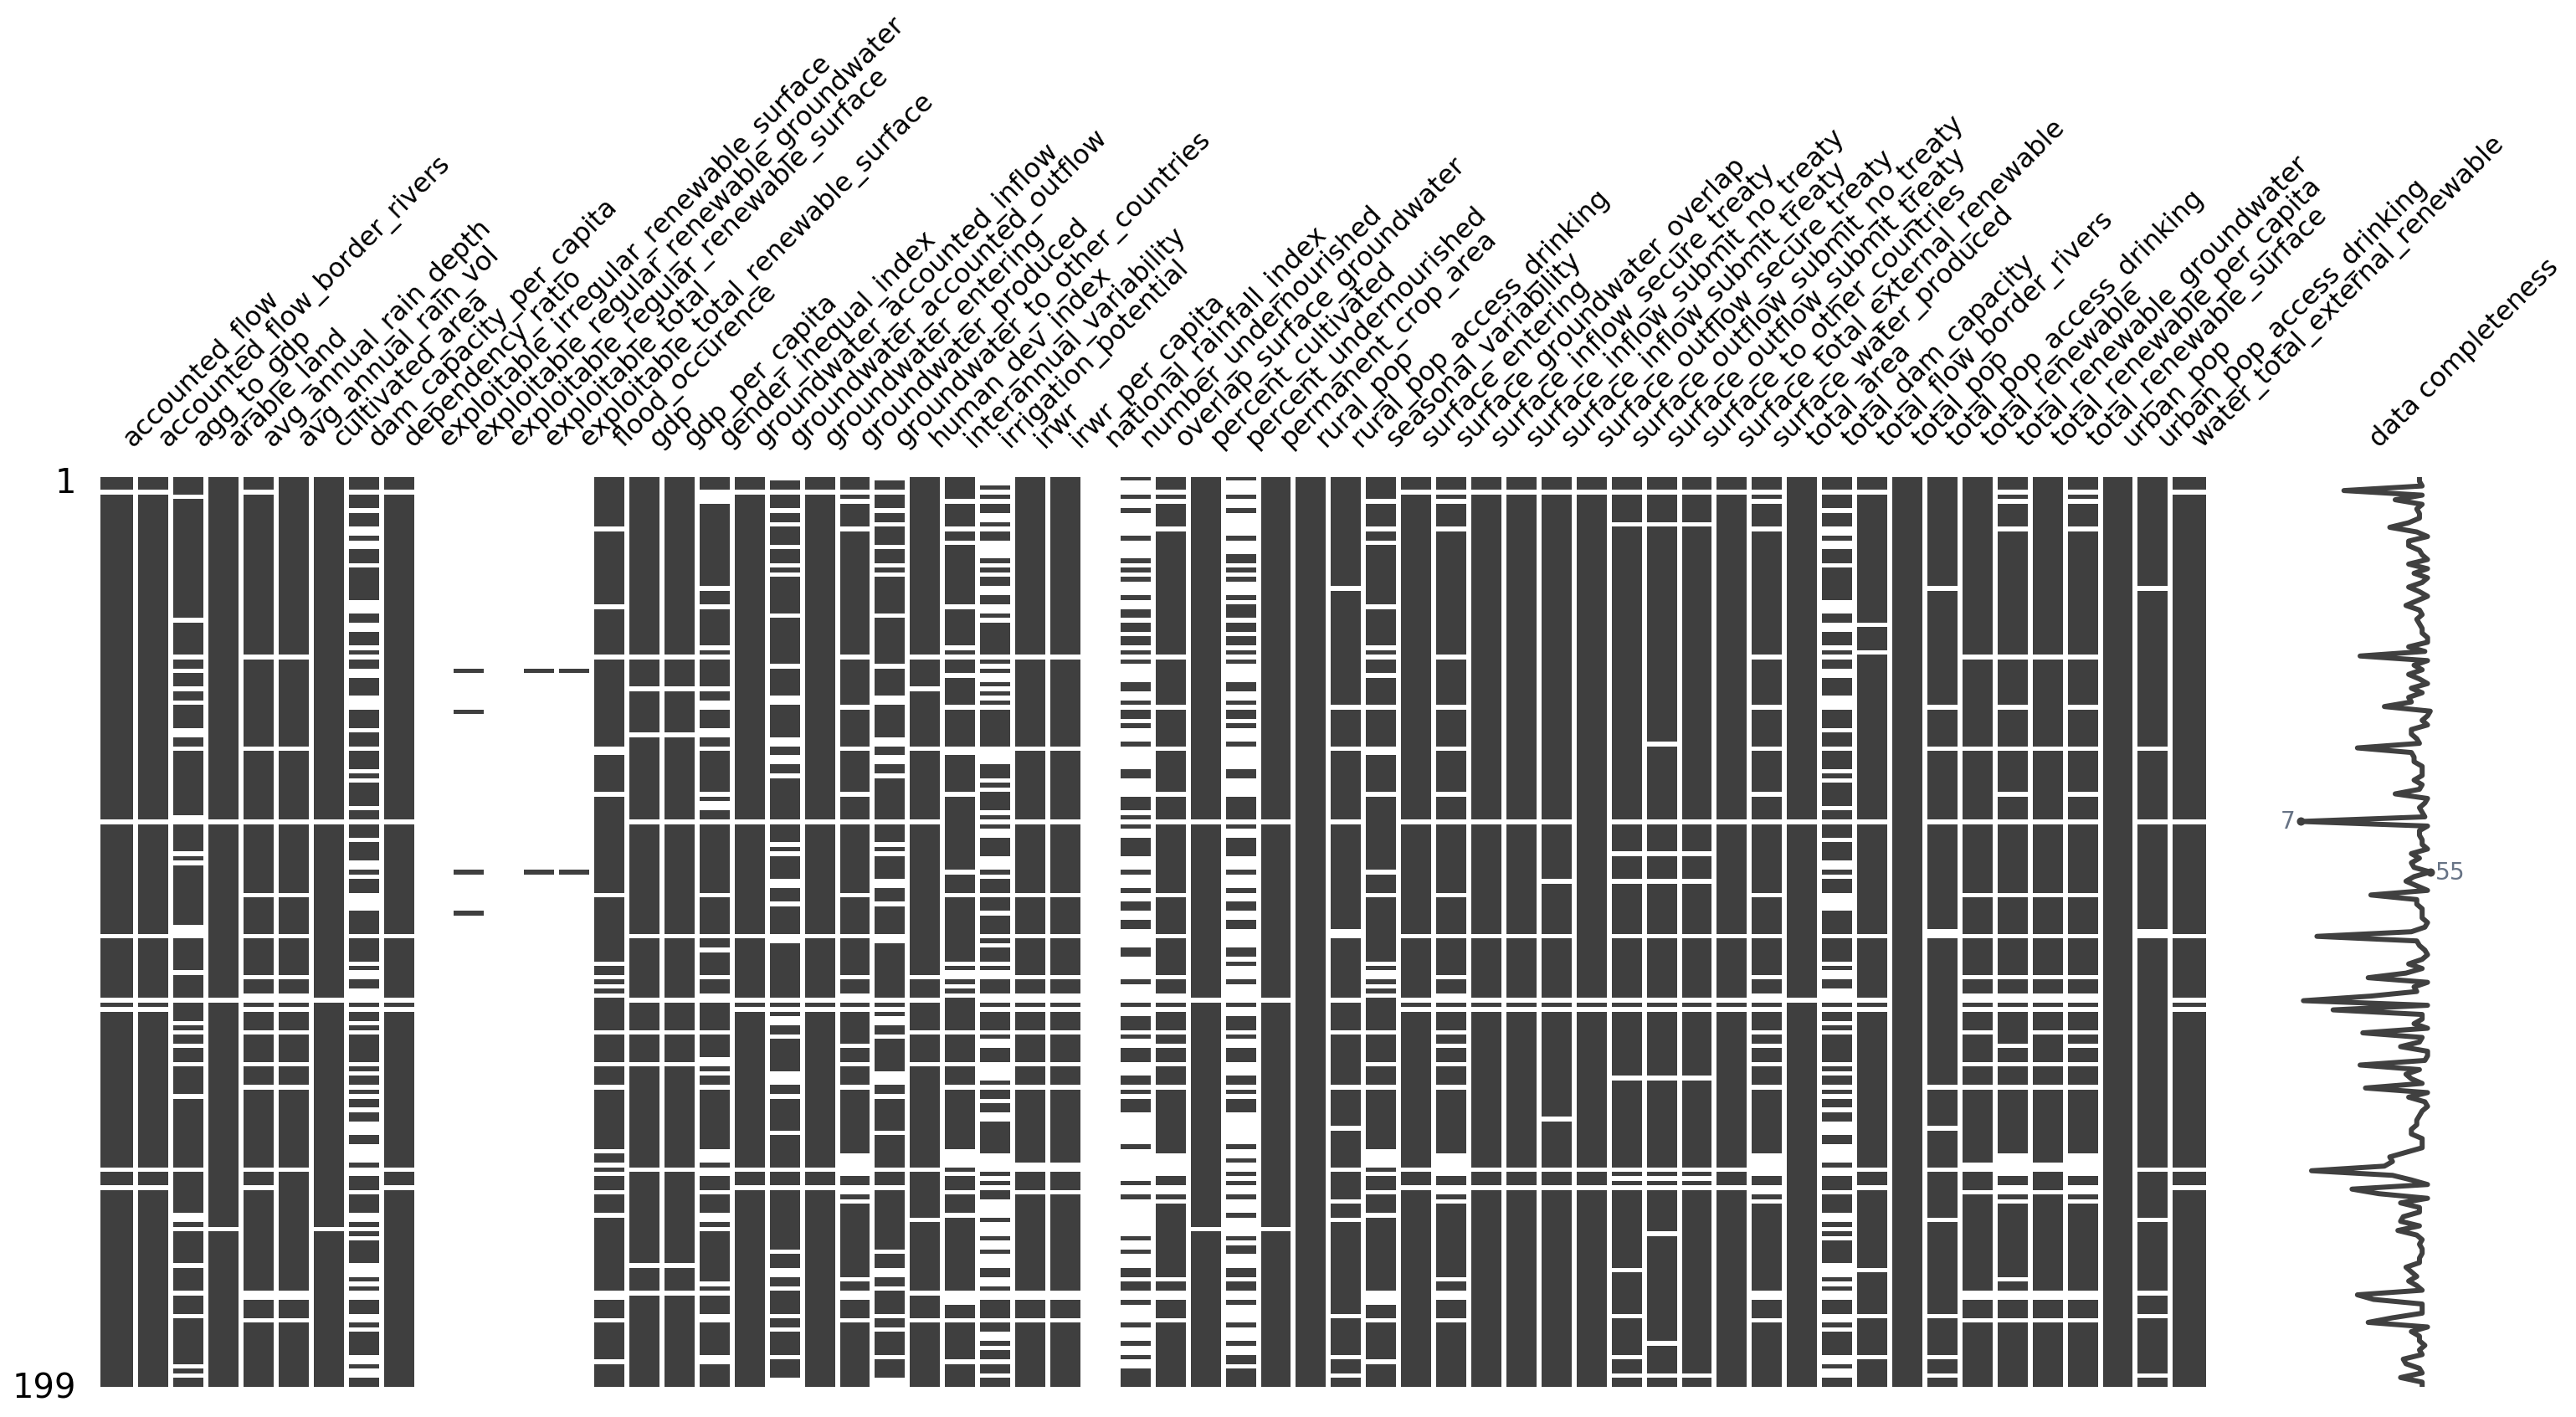

In [5]:
msno.matrix(recent, labels=True)

**Discussion:** What additional information does this provide or what additional questions does it suggest? 

#### Deep dive: *exploitable* variables 

"Exploitable" variables are missing for most countries. 

Question to consider: Does this happen in each time period? 

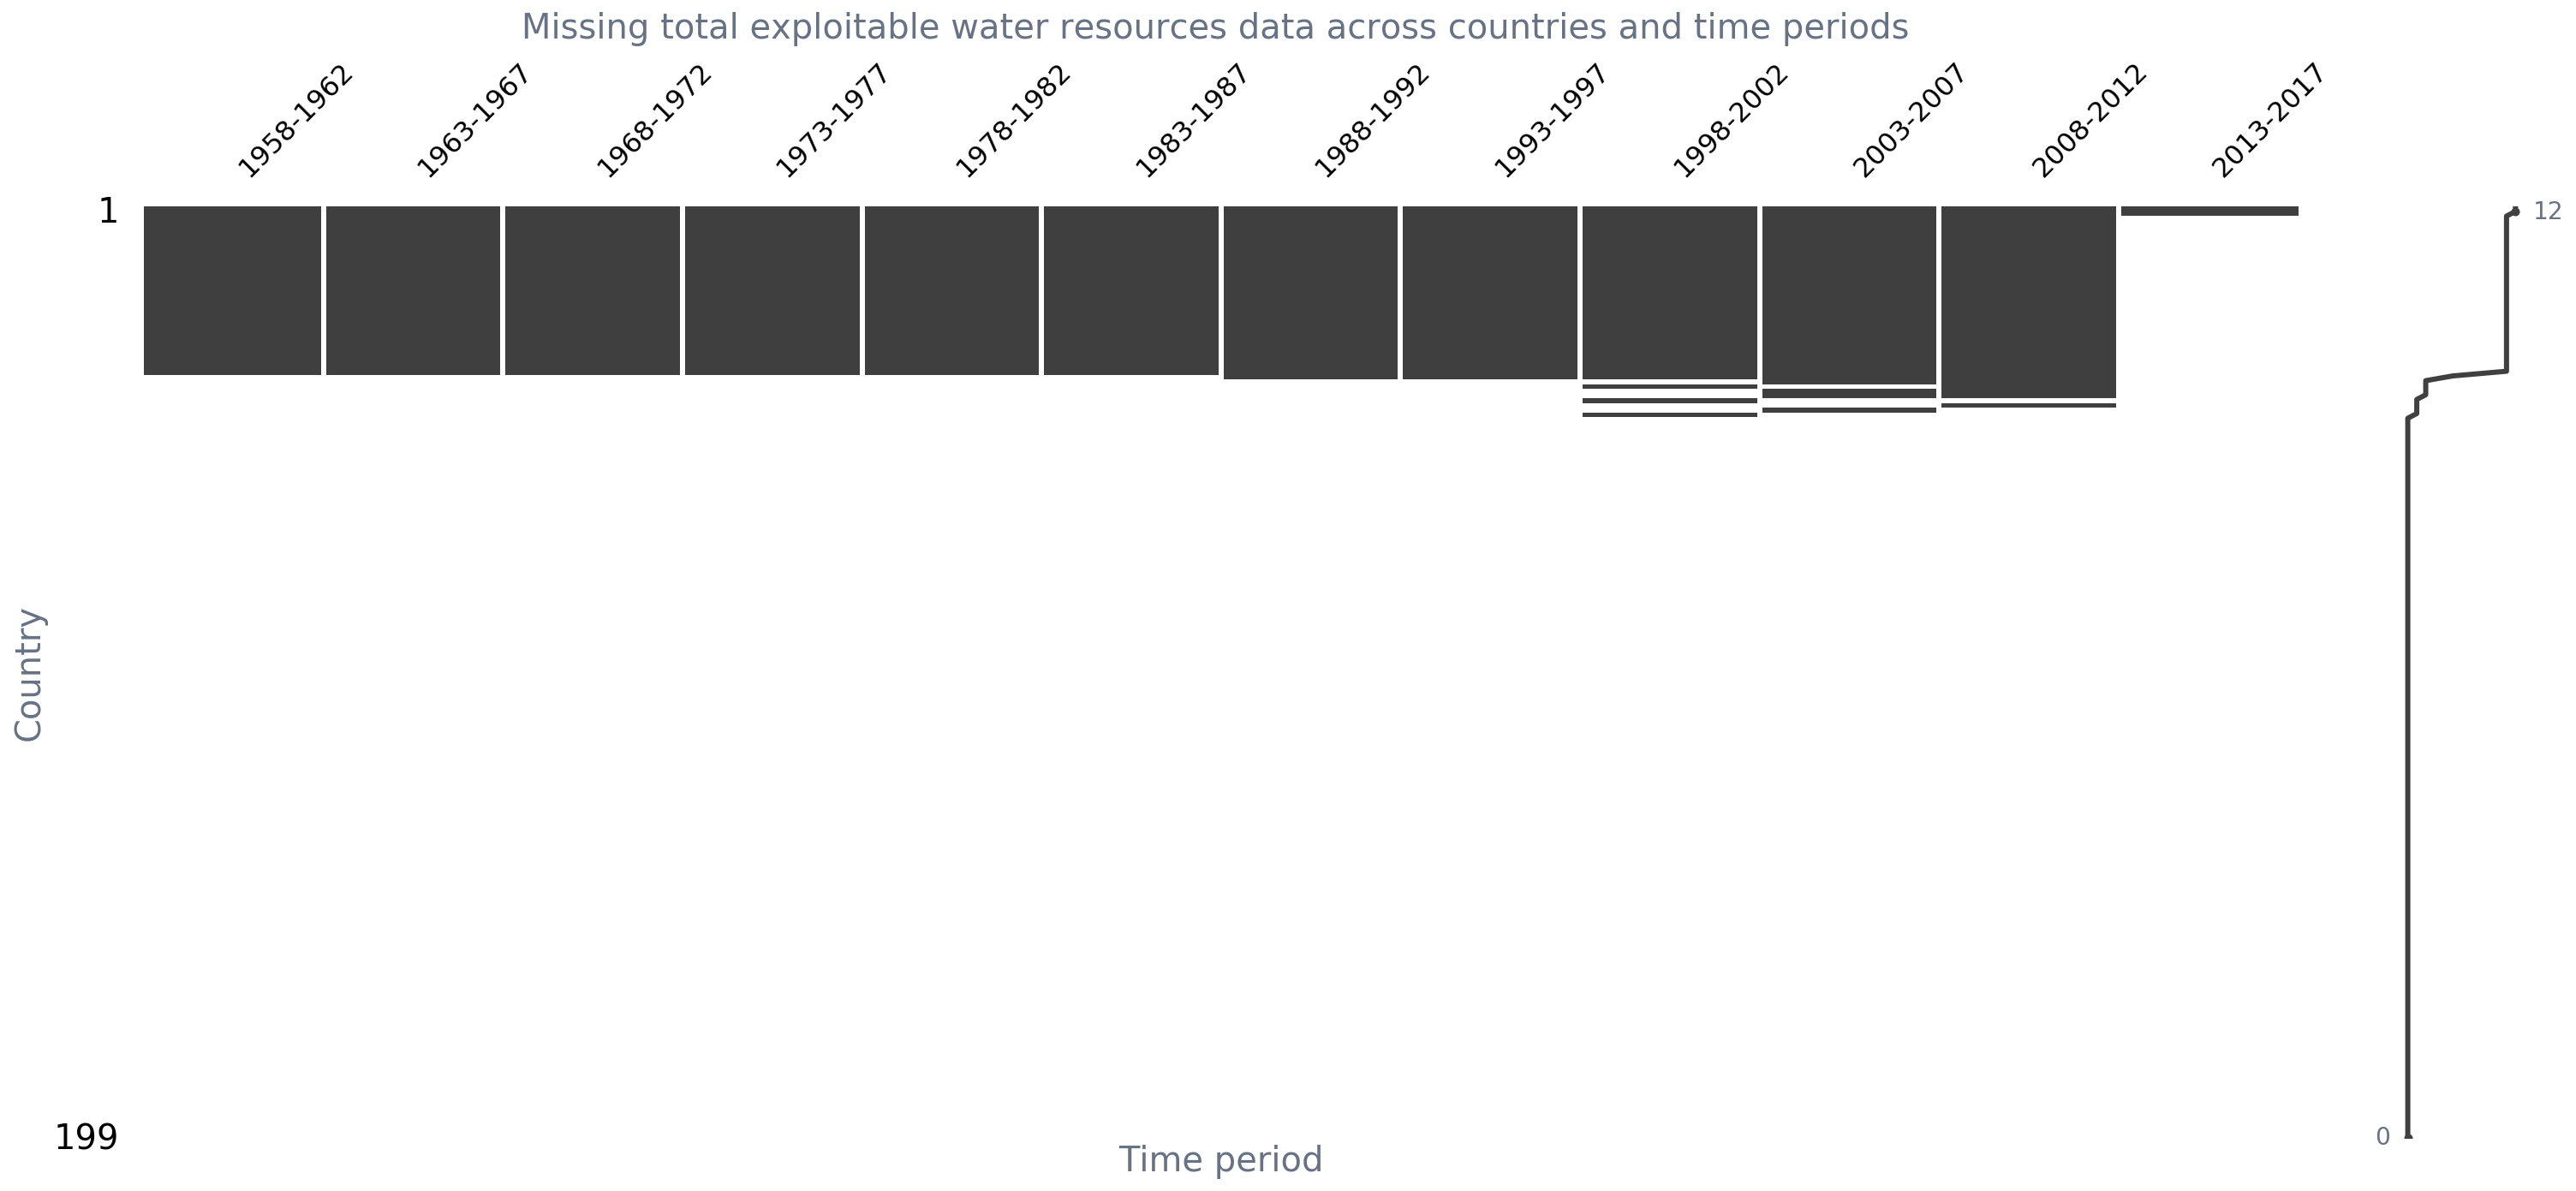

In [6]:
#Total exploitable water resources 水资源总量
msno.matrix(variable_slice(data, 'exploitable_total'), inline=False, sort='descending');
plt.xlabel('Time period');
plt.ylabel('Country');
plt.title('Missing total exploitable water resources data across countries and time periods \n \n \n \n');

只有一小部分国家报告了可利用的水资源总量，这些国家中只有极少数国家拥有最近一段时间的数据。 

我们将删除该变量，因为这么少的数据点会导致很多问题。 

In [7]:
data = data.loc[~data.variable.str.contains('exploitable'),:]

#### Deep dive: National rainfall index 

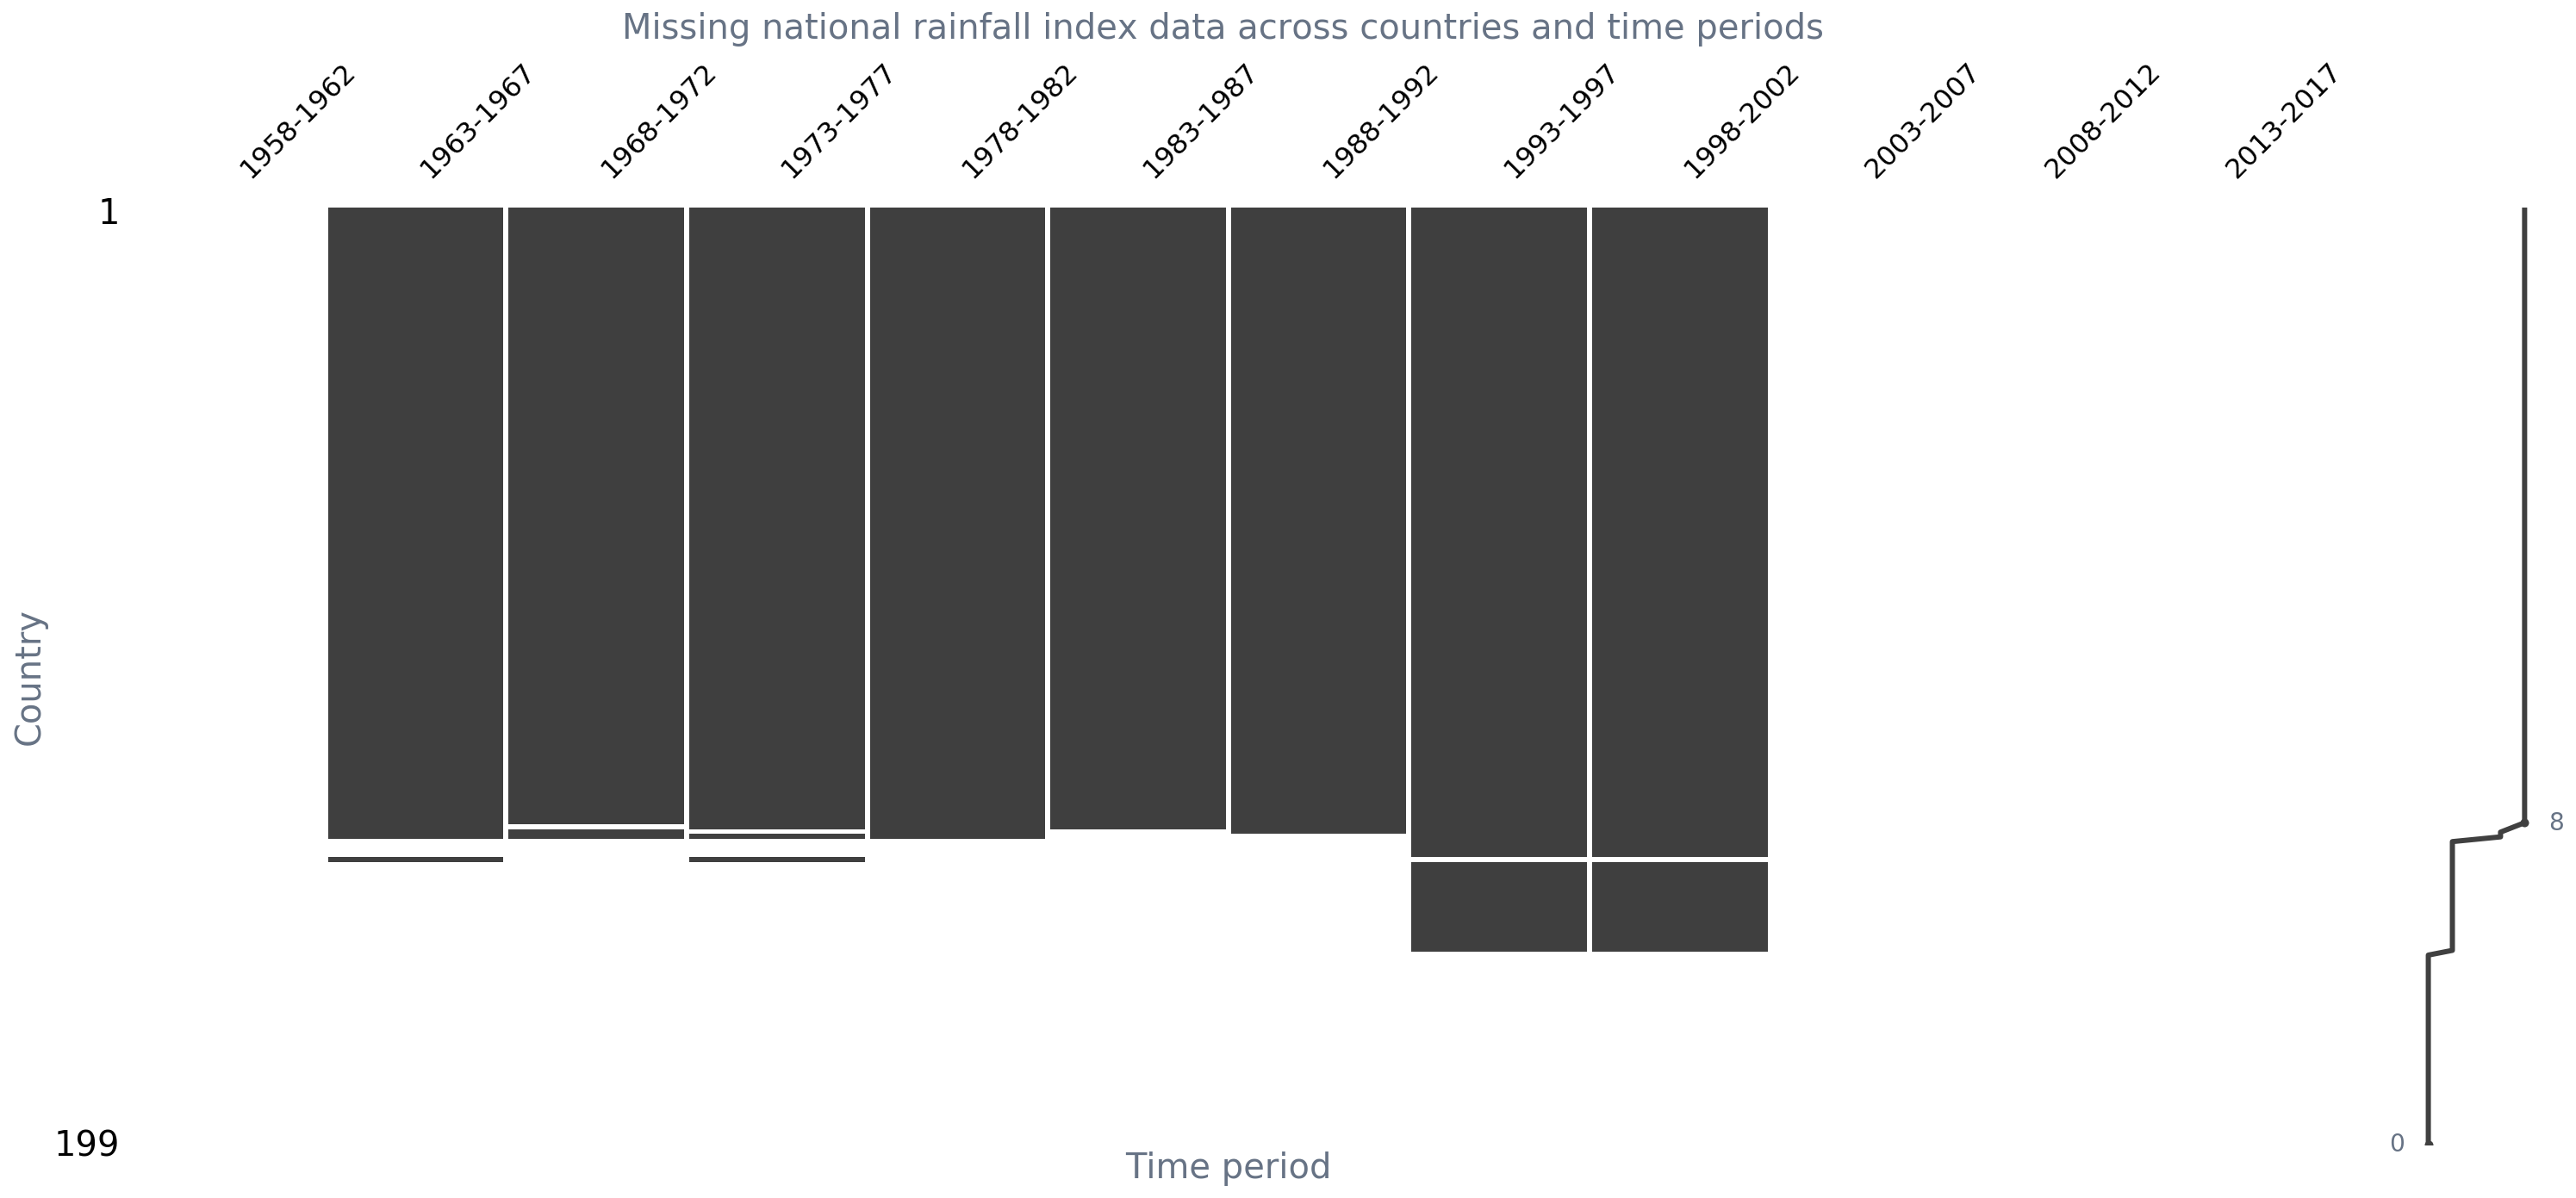

In [8]:
#national_rainfall_index 全国降水指数（NRI）（毫米/年)
msno.matrix(variable_slice(data, 'national_rainfall_index'), 
            inline=False, sort='descending');
plt.xlabel('Time period');
plt.ylabel('Country');
plt.title('Missing national rainfall index data across countries and time periods \n \n \n \n');

全国降雨指数在2002以后不再报告。

In [9]:
data = data.loc[~(data.variable=='national_rainfall_index')]

### By country

Let's look at North America only.

In [10]:
north_america = subregion(data, 'North America')

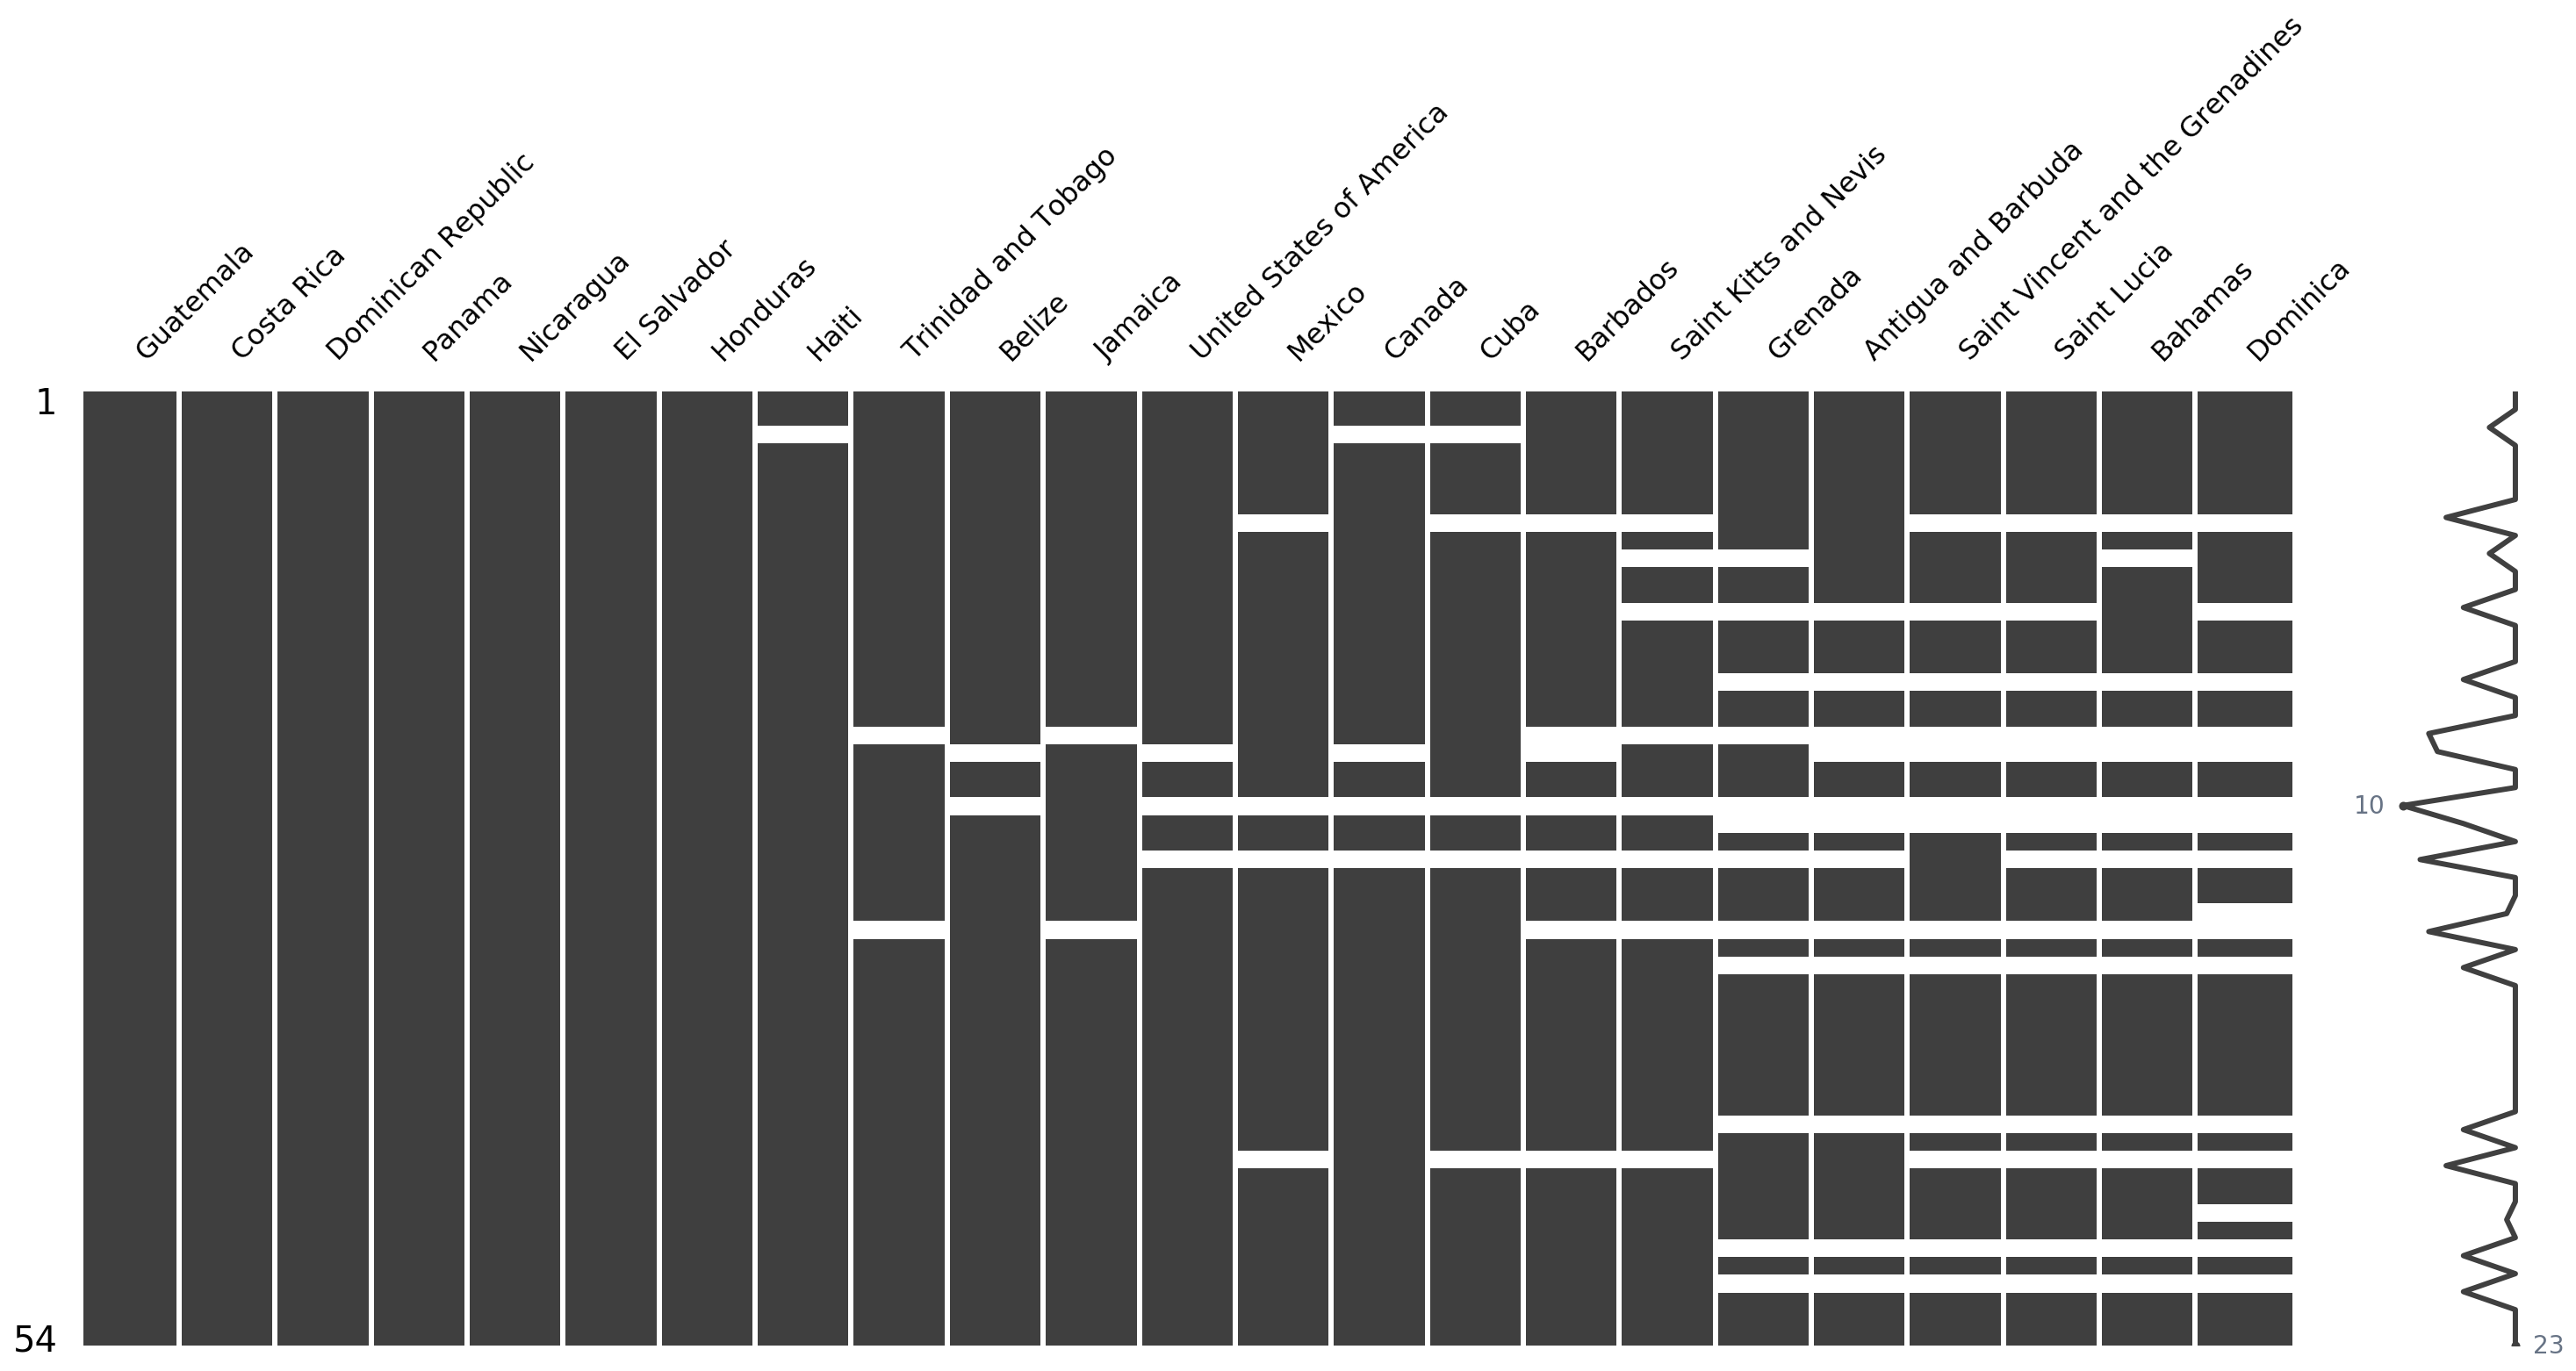

In [11]:
#指数完整性
msno.matrix(msno.nullity_sort(time_slice(north_america, '2013-2017'), sort='descending').T, inline=False)
#plt.title('Fraction of fields complete by country for North America \n \n');

**Question:** Is there any pattern in the countries with most missing data? 

**Question:** What are potential reasons for missing data? What can we check? 

抽查巴哈马缺少哪些数据以获得更多的了解 

In [12]:
msno.nullity_filter(country_slice(data, 'Bahamas').T, filter='bottom', p=0.1)

Bahamas,dam_capacity_per_capita,flood_occurence,gender_inequal_index,groundwater_produced,interannual_variability,irrigation_potential,number_undernourished,overlap_surface_groundwater,percent_undernourished,seasonal_variability,surface_groundwater_overlap,surface_water_produced,total_dam_capacity,total_renewable_groundwater,total_renewable_surface
time_period,,,,,,,,,,,,,,,
1958-1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-1967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1968-1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988-1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### By country for a single variable

In [13]:
# help(map.choropleth)

In [14]:
# JSON with coordinates for country boundaries 
geo = 'world.json'

null_data = recent['agg_to_gdp'].notnull()*1
map = folium.Map(location=[48, -102], zoom_start=2)
map.choropleth(geo_data=geo, 
               data=null_data,
               columns=['country', 'agg_to_gdp'],
               key_on='feature.properties.name', reset=True,
               fill_color='GnBu', fill_opacity=1, line_opacity=0.2,
               legend_name='Missing agricultural contribution to GDP data 2013-2017')
# map

**Question:** 苍白的浅绿色意味着什么？和绿色相比？（例如格陵兰对加拿大）

Now let's functionalize so we can look at other variables geospatially.

In [15]:
def plot_null_map(df, time_period, variable, 
                  legend_name=None):
    geo = 'world.json'
    
    
    ts = time_slice(df, time_period).reset_index().copy()
    ts[variable]=ts[variable].notnull()*1
    map = folium.Map(location=[48, -102], zoom_start=2)
    map.choropleth(geo_data=geo, 
                   data=ts,
                   columns=['country', variable],
                   key_on='feature.properties.name', reset=True,
                   fill_color='GnBu', fill_opacity=1, line_opacity=0.2,
                   legend_name=legend_name if legend_name else variable)
    return map

In [16]:
# plot_null_map(data, '2013-2017', 'number_undernourished', 'Number undernourished is missing')

**Question:** Are there any patterns in missing data? Any questions that come to mind for further investigation? 

### Over time

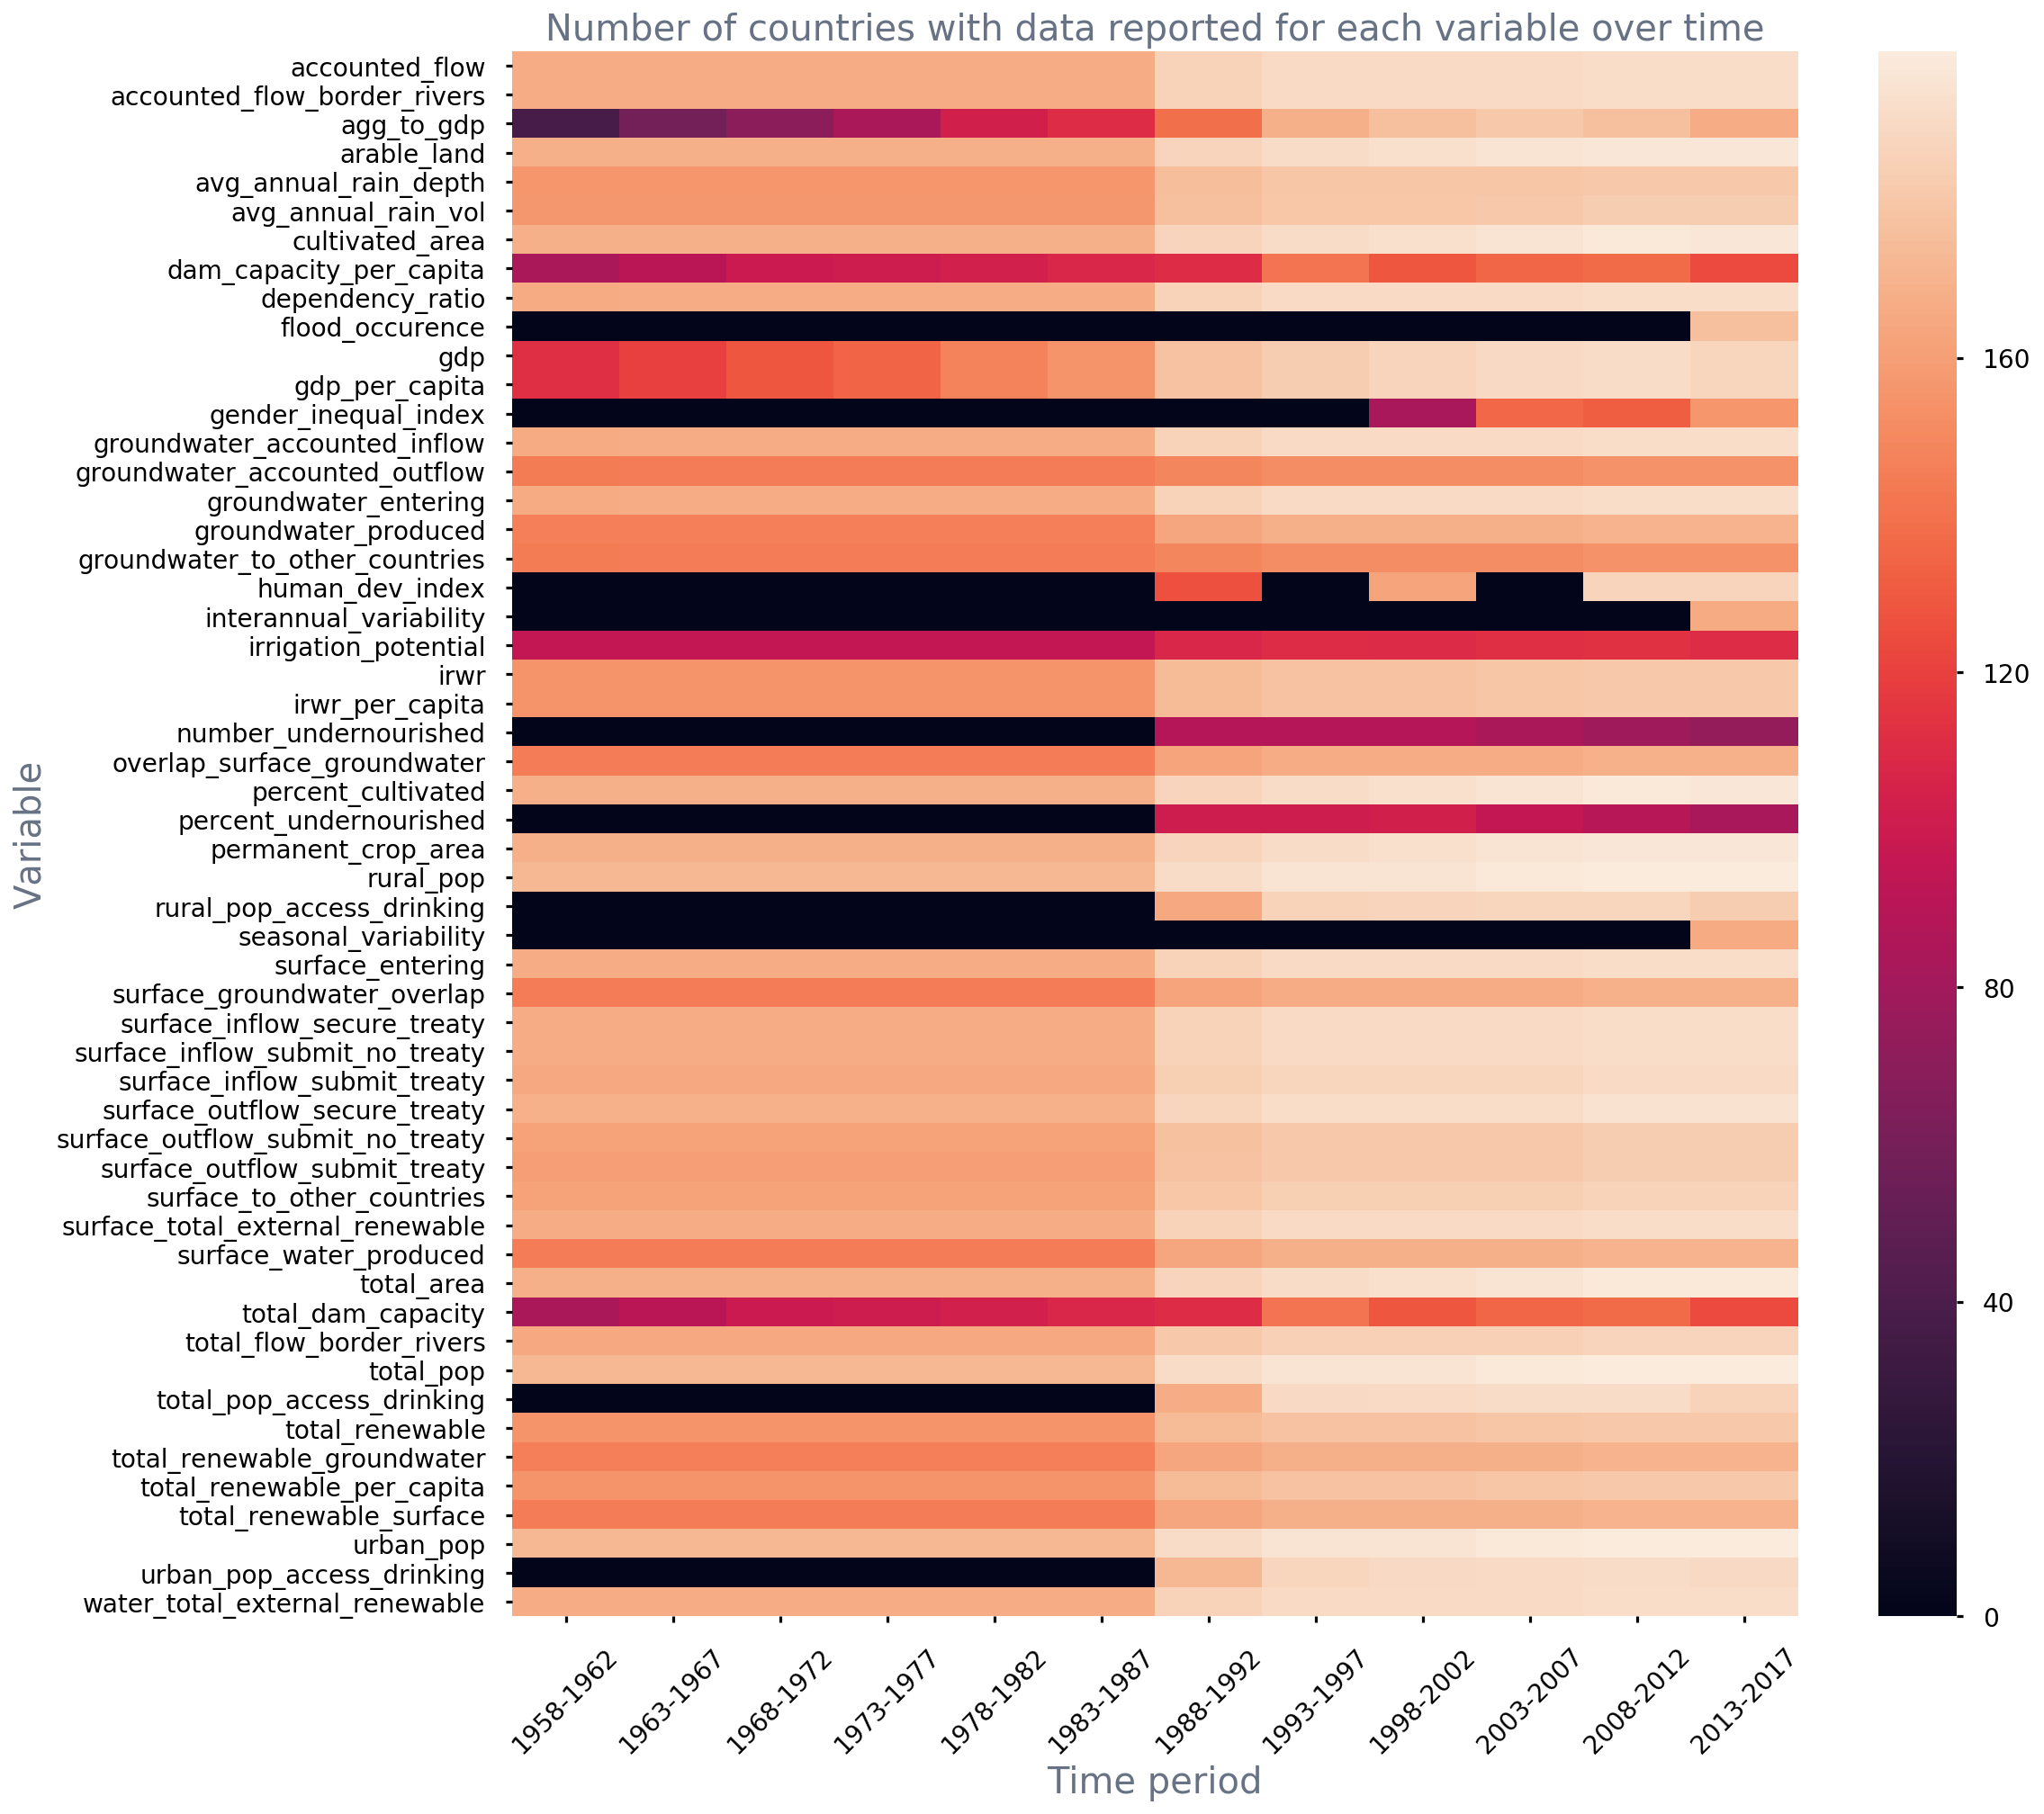

In [17]:
fig, ax = plt.subplots(figsize=(16, 16));
sns.heatmap(data.groupby(['time_period','variable']).value.count().unstack().T , ax=ax);
plt.xticks(rotation=45);
plt.xlabel('Time period');
plt.ylabel('Variable');
plt.title('Number of countries with data reported for each variable over time');

## Profiling 

在试图了解数据中哪些信息之前，请务必了解数据代表什么。
Sanity check! Do the values make sense? 

**Things to do:**
* Categorical: count, count distinct, assess unique values 
* Numerical: count, min, max
* Spot-check random samples
* Slice and dice 

**Questions to consider:**
* Are there frequent values that are default values? 
* Are there fields that represent the same information? 
* What timestamp should you use? 
* Are there numerical values reported as strings? 
* Are there special values? 
* Are there variables that are numerical but really should be categorical? 
* Is data consistent across different operating systems, device type, platforms, countries? 
* Are there any direct relationships between fields (e.g. a value of x always implies a specific value of y)? 
* What are the units of measurement? Are they consistent? 
* Is data consistent across the population and time? 
* Are there obvious changes in reported data around the time of important events that affect data generation (e.g. version release)?

这个阶段真的变成每一个你经常潜入每个变量逐一了解，单因素探索它，然后检查的再认识。不过，我们可以使用一些方便的Python包进行一些初步的概要分析。

### `pivottablejs`

In [18]:
#pivottablejs.pivot_ui(time_slice(data, '2013-2017'),)

### `pandas_profiling`

In [19]:
pandas_profiling.ProfileReport(time_slice(data, '2013-2017'))

Number of variables,55
Number of observations,199
Total Missing (%),6.4%
Total size in memory,85.6 KiB
Average record size in memory,440.4 B
Numeric,30
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,24
